# 03.3 Hypothesis Testing: The Logic of Statistical Significance

**Chapter**: 3 - Stats Review  
**Section**: 3 - Hypothesis Testing  
**Facure Source**: 03-Stats-Review-The-Most-Dangerous-Equation.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Null Hypothesis](#11-the-null-hypothesis)
   - 1.2 [Proof by Contradiction](#12-proof-by-contradiction)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Z-Statistics](#21-z-statistics)
   - 2.2 [P-Values](#22-p-values)
   - 2.3 [Type I and Type II Errors](#23-type-i-and-type-ii-errors)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Testing Treatment Effects](#31-testing-treatment-effects)
   - 3.2 [A/B Testing Framework](#32-ab-testing-framework)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from scipy import stats

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: Hypothesis testing logic is fundamental to A/B testing roles. Understanding p-values correctly is essential for data science interviews at tech companies.

### 1.1 The Null Hypothesis

Hypothesis testing follows **proof by contradiction**:

1. **Assume** the treatment has no effect (null hypothesis, H₀)
2. **Compute** how likely our data is under this assumption
3. **If very unlikely**, reject the assumption → conclude there IS an effect

### 1.2 Proof by Contradiction

Facure's analogy: Like proving an alibi in court.

- **H₀** (Null): "The defendant was at the crime scene" (no alibi)
- **Evidence**: Video showing defendant elsewhere at the time
- **Conclusion**: If H₀ were true, this evidence would be extremely unlikely → Reject H₀

★ Insight ─────────────────────────────────────
- We never "accept" the null—we fail to reject it
- Statistical significance ≠ practical significance
- p < 0.05 is convention, not law
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Z-Statistics

For testing the difference between two means:

$$\boxed{z = \frac{(\bar{X}_1 - \bar{X}_0) - \Delta_0}{\sqrt{SE_1^2 + SE_0^2}}}$$

where:
- $\bar{X}_1 - \bar{X}_0$ = observed difference
- $\Delta_0$ = hypothesized difference (usually 0 under H₀)
- $\sqrt{SE_1^2 + SE_0^2}$ = standard error of the difference

**Key property**: Under H₀, the z-statistic follows a standard normal distribution.

### 2.2 P-Values

$$p = P(|Z| > |z_{obs}| \mid H_0)$$

**Interpretation**: The probability of observing data **at least as extreme** as ours, **if the null hypothesis were true**.

**Critical misconception**: p-value is NOT P(H₀ is true | data). It's P(data | H₀).

**Decision rule**:
- If p < α (usually 0.05): Reject H₀ ("statistically significant")
- If p ≥ α: Fail to reject H₀

### 2.3 Type I and Type II Errors

| | H₀ True | H₀ False |
|---|---------|----------|
| **Reject H₀** | Type I Error (α) | Correct |
| **Fail to Reject** | Correct | Type II Error (β) |

- **Type I Error (α)**: False positive—claiming an effect when there isn't one
- **Type II Error (β)**: False negative—missing a real effect
- **Power = 1 - β**: Probability of detecting a true effect

---

## 3. Numeric Demonstration

### 3.1 Testing Treatment Effects

In [2]:
# Load Facure's classroom data
classroom = load_facure_data('online_classroom.csv')

# Split by format
online = classroom.query('format_ol == 1')['falsexam']
face_to_face = classroom.query('format_ol == 0 and format_blended == 0')['falsexam']

# Compute statistics
def get_stats(data):
    return {
        'n': len(data),
        'mean': np.mean(data),
        'std': np.std(data, ddof=1),
        'se': np.std(data, ddof=1) / np.sqrt(len(data))
    }

stats_online = get_stats(online)
stats_f2f = get_stats(face_to_face)

print("SAMPLE STATISTICS")
print("="*60)
print(f"{'Group':<15} {'n':>6} {'Mean':>10} {'Std':>10} {'SE':>10}")
print("-"*60)
print(f"{'Online':<15} {stats_online['n']:>6} {stats_online['mean']:>10.2f} {stats_online['std']:>10.2f} {stats_online['se']:>10.2f}")
print(f"{'Face-to-Face':<15} {stats_f2f['n']:>6} {stats_f2f['mean']:>10.2f} {stats_f2f['std']:>10.2f} {stats_f2f['se']:>10.2f}")

SAMPLE STATISTICS
Group                n       Mean        Std         SE
------------------------------------------------------------
Online              94      73.64      14.90       1.54
Face-to-Face       120      78.55       9.56       0.87


In [3]:
# Perform hypothesis test
def hypothesis_test(test_data, control_data, h0=0):
    """Two-sample z-test for difference in means."""
    # Compute sample statistics
    n1, n0 = len(test_data), len(control_data)
    mu1, mu0 = np.mean(test_data), np.mean(control_data)
    se1 = np.std(test_data, ddof=1) / np.sqrt(n1)
    se0 = np.std(control_data, ddof=1) / np.sqrt(n0)
    
    # Difference and its SE
    diff = mu1 - mu0
    se_diff = np.sqrt(se1**2 + se0**2)
    
    # Z-statistic
    z = (diff - h0) / se_diff
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return {
        'diff': diff,
        'se_diff': se_diff,
        'z': z,
        'p_value': p_value,
        'ci_lower': diff - 1.96 * se_diff,
        'ci_upper': diff + 1.96 * se_diff,
    }

result = hypothesis_test(online, face_to_face)

print("HYPOTHESIS TEST RESULTS")
print("="*60)
print(f"H₀: μ_online - μ_f2f = 0 (no difference)")
print(f"H₁: μ_online - μ_f2f ≠ 0 (there is a difference)")
print("-"*60)
print(f"Observed difference: {result['diff']:.2f}")
print(f"SE of difference:    {result['se_diff']:.2f}")
print(f"Z-statistic:         {result['z']:.3f}")
print(f"P-value:             {result['p_value']:.4f}")
print(f"95% CI:              [{result['ci_lower']:.2f}, {result['ci_upper']:.2f}]")
print("-"*60)
if result['p_value'] < 0.05:
    print("Conclusion: REJECT H₀ at α = 0.05")
    print("Online students performed significantly WORSE.")
else:
    print("Conclusion: FAIL TO REJECT H₀ at α = 0.05")

HYPOTHESIS TEST RESULTS
H₀: μ_online - μ_f2f = 0 (no difference)
H₁: μ_online - μ_f2f ≠ 0 (there is a difference)
------------------------------------------------------------
Observed difference: -4.91
SE of difference:    1.77
Z-statistic:         -2.779
P-value:             0.0054
95% CI:              [-8.38, -1.45]
------------------------------------------------------------
Conclusion: REJECT H₀ at α = 0.05
Online students performed significantly WORSE.


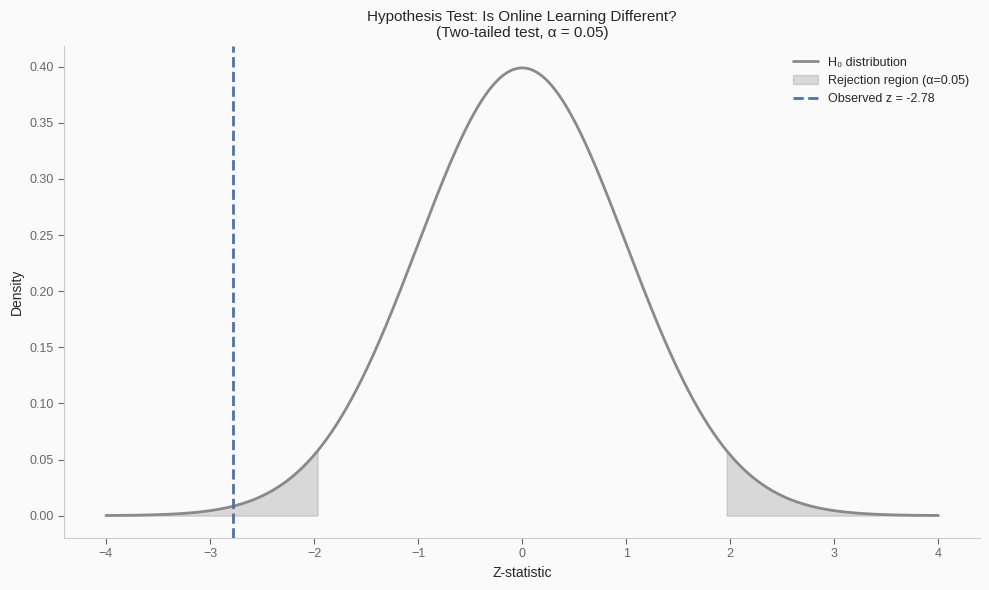


The observed z = -2.78 falls in the rejection region.
P-value = 0.0054 < 0.05, so we reject H₀.


In [4]:
# Visualize the test
fig, ax = create_tufte_figure(1, 1, figsize=(10, 6))

# Plot the null distribution
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x)
ax.plot(x, y, color=TUFTE_PALETTE['secondary'], linewidth=2, label='H₀ distribution')

# Shade rejection regions
ax.fill_between(x[x <= -1.96], y[x <= -1.96], alpha=0.3, 
                color=TUFTE_PALETTE['control'], label='Rejection region (α=0.05)')
ax.fill_between(x[x >= 1.96], y[x >= 1.96], alpha=0.3, 
                color=TUFTE_PALETTE['control'])

# Mark the observed z-statistic
ax.axvline(result['z'], color=TUFTE_PALETTE['treatment'], linewidth=2, 
           linestyle='--', label=f'Observed z = {result["z"]:.2f}')

ax.set_xlabel('Z-statistic')
ax.set_ylabel('Density')
ax.set_title('Hypothesis Test: Is Online Learning Different?\n(Two-tailed test, α = 0.05)')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print(f"\nThe observed z = {result['z']:.2f} falls in the rejection region.")
print(f"P-value = {result['p_value']:.4f} < 0.05, so we reject H₀.")

### 3.2 A/B Testing Framework

In [5]:
def AB_test(test, control, confidence=0.95, h0=0):
    """
    Complete A/B test with all relevant statistics.
    
    Parameters
    ----------
    test : pd.Series or np.array
        Test group outcomes
    control : pd.Series or np.array
        Control group outcomes
    confidence : float
        Confidence level (default 0.95)
    h0 : float
        Null hypothesis value for difference (default 0)
    
    Returns
    -------
    dict : Complete test results
    """
    # Sample statistics
    n_test, n_control = len(test), len(control)
    mu_test, mu_control = np.mean(test), np.mean(control)
    se_test = np.std(test, ddof=1) / np.sqrt(n_test)
    se_control = np.std(control, ddof=1) / np.sqrt(n_control)
    
    # Difference statistics
    diff = mu_test - mu_control
    se_diff = np.sqrt(se_test**2 + se_control**2)
    
    # Critical value
    z_crit = stats.norm.ppf(1 - (1 - confidence) / 2)
    
    # Test statistic and p-value
    z = (diff - h0) / se_diff
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((
        (n_test - 1) * np.var(test, ddof=1) + 
        (n_control - 1) * np.var(control, ddof=1)
    ) / (n_test + n_control - 2))
    cohens_d = diff / pooled_std
    
    return {
        # Sample info
        'n_test': n_test,
        'n_control': n_control,
        'mu_test': mu_test,
        'mu_control': mu_control,
        'se_test': se_test,
        'se_control': se_control,
        # Test results
        'difference': diff,
        'se_diff': se_diff,
        'z_stat': z,
        'p_value': p_value,
        'ci_lower': diff - z_crit * se_diff,
        'ci_upper': diff + z_crit * se_diff,
        # Effect size
        'cohens_d': cohens_d,
        # Decision
        'significant': p_value < (1 - confidence),
    }

# Run the A/B test
ab_result = AB_test(online, face_to_face)

print("A/B TEST REPORT")
print("="*60)
print(f"Test Group (Online):    n={ab_result['n_test']}, μ={ab_result['mu_test']:.2f}, SE={ab_result['se_test']:.2f}")
print(f"Control Group (F2F):    n={ab_result['n_control']}, μ={ab_result['mu_control']:.2f}, SE={ab_result['se_control']:.2f}")
print("-"*60)
print(f"Difference:             {ab_result['difference']:.2f}")
print(f"95% CI:                 [{ab_result['ci_lower']:.2f}, {ab_result['ci_upper']:.2f}]")
print(f"Z-statistic:            {ab_result['z_stat']:.3f}")
print(f"P-value:                {ab_result['p_value']:.4f}")
print(f"Cohen's d:              {ab_result['cohens_d']:.3f}")
print("-"*60)
print(f"Significant at α=0.05:  {'YES' if ab_result['significant'] else 'NO'}")

A/B TEST REPORT
Test Group (Online):    n=94, μ=73.64, SE=1.54
Control Group (F2F):    n=120, μ=78.55, SE=0.87
------------------------------------------------------------
Difference:             -4.91
95% CI:                 [-8.38, -1.45]
Z-statistic:            -2.779
P-value:                0.0054
Cohen's d:              -0.403
------------------------------------------------------------
Significant at α=0.05:  YES


---

## 4. Implementation

```python
from scipy import stats

# Method 1: Manual z-test (as shown above)
z = (diff - h0) / se_diff
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

# Method 2: Using scipy's ttest_ind
t_stat, p_value = stats.ttest_ind(test, control)

# Method 3: Using statsmodels
from statsmodels.stats.weightstats import ttest_ind
t_stat, p_value, df = ttest_ind(test, control)

# In practice: Use causal_inference_mastery
from causal_inference.rct import simple_ate
result = simple_ate(outcome, treatment)
print(f"ATE = {result.ate:.3f}, p = {result.p_value:.4f}")
```

---

## 5. Interview Appendix

**Q1 (Google, Uber)**: *"What is a p-value?"*

<details><summary>Solution</summary>

A p-value is the probability of observing data at least as extreme as what we observed, **assuming the null hypothesis is true**.

Mathematically: p = P(|T| ≥ |t_obs| | H₀)

**Critical misconceptions to avoid**:
- NOT P(H₀ is true | data) — that would require Bayes' theorem
- NOT the probability of making an error
- NOT the probability the result is due to chance

A small p-value means: "If there were no effect, data this extreme would be rare."

</details>

**Q2 (Meta, Netflix)**: *"What's the difference between Type I and Type II errors? Which is worse?"*

<details><summary>Solution</summary>

**Type I Error (α)**: False positive—rejecting H₀ when it's true
- Example: Claiming a drug works when it doesn't

**Type II Error (β)**: False negative—failing to reject H₀ when it's false
- Example: Missing a drug that actually works

**Which is worse?** Depends on context:
- Medical trial: Type I is worse (harmful treatment deployed)
- A/B testing a button color: Type II is worse (missed opportunity)
- Criminal trial: Type I is worse (convicting innocent)

There's a trade-off: Reducing α increases β (and vice versa). Power analysis helps balance.

</details>

**Q3 (Stripe, Airbnb)**: *"Your A/B test shows p = 0.048. The business wants to ship the feature. What do you say?"*

<details><summary>Solution</summary>

Considerations beyond p < 0.05:

1. **Effect size**: Is the improvement meaningful? A 0.1% conversion increase might not justify engineering effort.

2. **Multiple comparisons**: If you tested 20 metrics, expect 1 false positive at α=0.05. Was this the primary metric?

3. **Test duration**: Did you stop early? Peeking inflates false positives.

4. **Sample ratio mismatch**: Were groups actually balanced?

5. **Business context**: Is 0.048 robust enough for the decision's cost?

My recommendation: "p = 0.048 suggests the effect is likely real, but I'd want to see the effect size, check for multiple testing issues, and possibly run a confirmation test before shipping."

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 3.

[^2]: Fisher, R. A. (1925). *Statistical Methods for Research Workers*. Oliver and Boyd.

[^3]: Neyman, J., & Pearson, E. S. (1933). On the problem of the most efficient tests of statistical hypotheses. *Phil. Trans. R. Soc. A*, 231, 289-337.

[^4]: Wasserstein, R. L., & Lazar, N. A. (2016). The ASA's statement on p-values: context, process, and purpose. *The American Statistician*, 70(2), 129-133.